In [1]:
import matplotlib.image as image
import os
import subprocess
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

/home/lucas/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Copiamos las imagenes de oscuro a la carpeta todas

In [2]:
# copiamos las imagenes de oscuro a la carpeta todas
directory = '../im/oscuro/'
for filename in os.listdir(directory):
    img = image.imread(directory + filename)
    image.imsave("../im/todas/" + filename, img)

Pasamos las imagenes claras a oscuras

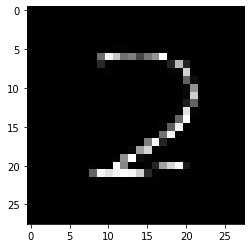

In [3]:
# pasamos las imagenes claras a oscuras
directory = '../im/claro/'
for filename in os.listdir(directory):
    img = image.imread(directory + filename)
    plt.imshow(img, cmap="Greys")
    v = img[:,:,:3]  # tomamos la matriz R (R = G = B en este caso)
    v = 1 - v  # pasamos a modo oscuro
    img[:,:,:3] = v
    plt.imshow(img, cmap="Greys")
    image.imsave("../im/invertidas/" + filename, img)
    image.imsave("../im/todas/" + filename, img)

Pasamos todas las imagenes a vectores (con algun cuidado extra sobre RGB vs RGBA) y luego las pasamos a .csv

In [4]:
# dado un filename consigue el label de esa imagen (decidimos poner los labels como el ultimo caracter del nombre del archivo antes de .png)
def label(filename):
    for i in range(len(filename)):
        if filename[i] == '.':
            return filename[i-1]

pixeles = []
for i in range(783):
    pixeles.append("pixel" + str(i) + ',')
pixeles.append("pixel783")
pixeles = ' '.join(pixeles)
pixeles = pixeles.replace(" ", "")

# pasamos todas las imagenes a vectores y las pasamos de RGB/RGBA[0-1] a GS[0-255] luego las pasamos a .csv
directory = '../im/todas/'
with open(f"../csv/testAMano.csv", 'w') as f:
    with open(f"../csv/expectedAMano.csv", 'w') as fe:
        i = 0
        f.write(pixeles + '\n')  # pongo la primer linea de test
        fe.write("ImageId,Label" + '\n')  # pongo la primer linea de expected
        for filename in os.listdir(directory):
            #if filename.startswith('J') or filename.startswith('L'):
            if True:
                img = image.imread(directory + filename)
                v = img[:,:,:3]  # tomamos las matrices R, G y B (R = G = B en este caso, ignoramos la matriz A en caso de que exista)
                v = v * 255  # queremos numeros entre 0 y 255
                v = np.round(v)  # queremos numeros enteros
                v = v.astype(int)
                img[:,:,:3] = v
                img = img[:,:,0]  # tomamos solo la matriz R (recordemos R = G = B)
                #plt.imshow(img, cmap = "gray", vmin = 0, vmax = 255)
                image.imsave("../im/ImageId/" + str(i+1) + '.png', img, cmap = "gray", vmin = 0, vmax = 255)
                img = img.reshape(784)  # reshape de 28x28 a 784 para escribirlo como vector en .csv
                img = img.astype(int)
                i = i + 1
                labelf = label(filename)  # conseguimos el label de la imagen
                fe.write(str(i) + ',' + labelf)  # escribimos ImageId y Label (mismo formato que test de kaggle, hay que acordarse de poner la primer linea)
                fe.write('\n')
                for j in range(img.size - 1):
                    f.write(str(img[j]) + ',')
                f.write(str(img[img.size - 1]))
                f.write('\n')
        fe.close
    f.close

Codigo para ver una imagen especifica de alguna de las bases (grupo, avect, kaggle test/train)

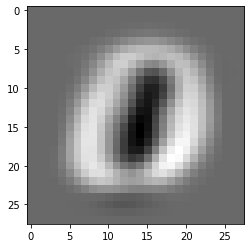

In [4]:
base = int(input("Imagen de que base?: [0] grupo, [1] avects de ultima corrida, [2] kaggle test, [3] kaggle train"))
if base == 1:
    imagenes = pd.read_csv("../csv/avect.csv", delimiter=',')
elif base == 2:
    imagenes = pd.read_csv("../csv/test.csv", delimiter=',')
elif base == 3:
    imagenes = pd.read_csv("../csv/train.csv", delimiter=',')
else:
    imagenes = pd.read_csv("../csv/testAMano.csv", delimiter=',')

numIm = int(input("Numero de imagen: "))

rtk = [False] * imagenes.shape[0]
rtk[numIm] = True

img = imagenes[rtk].to_numpy()
if base == 3:
    img = np.delete(img, 0)
img = img.reshape(28,28)
plt.imshow(img, cmap="gray")

Imprimimos la media de las imagenes

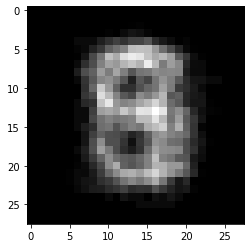

In [5]:
imagenes = pd.read_csv("../csv/testAMano.csv", delimiter=',')
img = imagenes.to_numpy()
mu = img.sum(axis=0)/img.shape[0]
mu = mu.reshape(28,28)
plt.imshow(mu, cmap="gray")

Probamos la accuracy con distintos parametros en PCA

In [7]:
PCAbool = str("1")
k = str("1")
votPes = str("1")
alpha = str("50")
epsilon = str("1e-6")
outCsv = str("aManoGuess.csv")

expected = pd.read_csv("../csv/expectedAMano.csv")

comando = ["../cpp/tp2", PCAbool, k, votPes, alpha, epsilon, "train.csv", "testAMano.csv", outCsv, "0", "1", "0", "0"]

alphas = range(55, 24, -1)
ks = [10,9,8,7,6,5,4,3,1]

#alphas = [35]
#ks = [3]

for alpha in tqdm(alphas):
    for k in ks:
        for votPes in range(2):
            comando[2] = str(k)
            comando[3] = str(votPes)
            comando[4] = str(alpha)
            if alpha == max(alphas) and k == max(ks) and votPes == 0:
                comando[9:]=["1", "1", "0", "0"]
            elif k == max(ks) and votPes == 0:
                comando[9:]=["1", "0", "0", "1"]
            else:
                comando[9:]=["0", "0", "1", "0"]
            result = subprocess.run(comando, stdout=subprocess.PIPE, encoding='ascii')
            #print(result.stdout)

            salida = pd.read_csv("../csv/" + outCsv, delimiter=',')
            salida['match'] = np.where(salida['Label'] == expected['Label'], 'True', 'False')

            matches = salida['match'].value_counts()

            percent = str((matches["True"] / salida.shape[0]) * 100)
            with open(f"../csv/resIm.csv", 'a') as f:
                f.write(str(k) + ',' + str(votPes) + ',' + str(alpha) + ',' + str(percent) + '\n')
                f.close()
            #print(str(alpha) + ' ' + str(k) + ' ' + str(matches["True"]))

100%|██████████| 1/1 [00:06<00:00,  6.86s/it]
